# Projeto Kobe Shot Prediction - Pipeline Completo
Este notebook documenta todas as etapas do pipeline de Machine Learning para prever se Kobe Bryant acertou ou errou arremessos, desde o pré-processamento dos dados até a escolha do melhor modelo.

## 1. Carregamento e Pré-processamento dos Dados

In [4]:
import pandas as pd

# Carregar base de dados
df = pd.read_parquet('../data/01_raw/dataset_kobe_dev.parquet')

print("antes da limpeza")
print(df.shape)

# Selecionar apenas as colunas solicitadas
cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
df = df[cols]

# Remover linhas com dados faltantes
df = df.dropna()

# Exibir dimensões do dataset limpo
print("após da limpeza")
df.shape

antes da limpeza
(24271, 25)
após da limpeza


(20285, 7)

## 2. Divisão em treino e teste

In [5]:
from sklearn.model_selection import train_test_split

# Separação estratificada
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['shot_made_flag'])

train_df.shape, test_df.shape

((16228, 7), (4057, 7))

## 3. Treinamento dos Modelos com PyCaret

In [6]:
from pycaret.classification import setup, create_model, predict_model, save_model
from sklearn.metrics import log_loss, f1_score

# Setup do PyCaret (sem log de experimento)
setup(
    data=train_df,
    target='shot_made_flag',
    session_id=123,
    log_experiment=False,
    html=False
)

# Regressão Logística
lr_model = create_model('lr')
lr_preds = predict_model(lr_model, data=test_df)

# Métricas manuais
print("Log Loss (LR):", log_loss(test_df['shot_made_flag'], lr_preds['prediction_label']))
print("F1 Score (LR):", f1_score(test_df['shot_made_flag'], lr_preds['prediction_label']))


# Árvore de Decisão
dt_model = create_model('dt')
dt_preds = predict_model(dt_model, data=test_df)

# Métricas manuais
print("Log Loss (DT):", log_loss(test_df['shot_made_flag'], dt_preds['prediction_label']))
print("F1 Score (DT):", f1_score(test_df['shot_made_flag'], dt_preds['prediction_label']))


                    Description             Value
0                    Session id               123
1                        Target    shot_made_flag
2                   Target type            Binary
3           Original data shape        (16228, 7)
4        Transformed data shape        (16228, 7)
5   Transformed train set shape        (11359, 7)
6    Transformed test set shape         (4869, 7)
7              Numeric features                 6
8                    Preprocess              True
9               Imputation type            simple
10           Numeric imputation              mean
11       Categorical imputation              mode
12               Fold Generator   StratifiedKFold
13                  Fold Number                10
14                     CPU Jobs                -1
15                      Use GPU             False
16               Log Experiment             False
17              Experiment Name  clf-default-name
18                          USI              c779


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5827  0.6132  0.4815  0.5749  0.5241  0.1578  0.1597
1       0.5731  0.5971  0.4926  0.5597  0.5240  0.1398  0.1408
2       0.5634  0.6087  0.4963  0.5467  0.5203  0.1214  0.1219
3       0.5625  0.5855  0.4760  0.5478  0.5094  0.1181  0.1191
4       0.5651  0.5791  0.4631  0.5529  0.5040  0.1222  0.1237
5       0.6109  0.6517  0.5258  0.6064  0.5632  0.2156  0.2174
6       0.5810  0.5754  0.4871  0.5714  0.5259  0.1548  0.1563
7       0.5880  0.6075  0.4899  0.5821  0.5320  0.1689  0.1709
8       0.5863  0.5947  0.5138  0.5753  0.5428  0.1672  0.1681
9       0.5859  0.6043  0.5092  0.5750  0.5401  0.1660  0.1670
Mean    0.5799  0.6017  0.4935  0.5692  0.5286  0.1532  0.1545
Std     0.0140  0.0206  0.0177  0.0172  0.0162  0.0281  0.0284
                 Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Logistic Regression    0.5721  0.5942  

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.5317  0.5118  0.5461  0.5086  0.5267  0.0644  0.0646
1       0.5202  0.5061  0.5517  0.4975  0.5232  0.0430  0.0433
2       0.5343  0.5136  0.5498  0.5111  0.5298  0.0698  0.0700
3       0.5449  0.5371  0.6052  0.5198  0.5592  0.0944  0.0956
4       0.5273  0.5161  0.5517  0.5042  0.5269  0.0565  0.0567
5       0.5537  0.5361  0.5886  0.5290  0.5572  0.1099  0.1105
6       0.5238  0.5134  0.5572  0.5008  0.5275  0.0502  0.0505
7       0.5519  0.5387  0.5875  0.5281  0.5562  0.1064  0.1070
8       0.5255  0.5135  0.5470  0.5034  0.5243  0.0527  0.0529
9       0.5269  0.5222  0.5793  0.5040  0.5391  0.0579  0.0585
Mean    0.5340  0.5209  0.5664  0.5107  0.5370  0.0705  0.0709
Std     0.0114  0.0114  0.0205  0.0107  0.0141  0.0230  0.0232
                      Model  Accuracy     AUC  Recall  Prec.      F1   Kappa  \
0  Decision Tree Classifier    0.5329 

## 4. Comparação dos Modelos

In [7]:
# Verdadeiros valores
y_true = test_df['shot_made_flag']

# Métricas isoladas
log_loss_lr = log_loss(y_true, lr_preds['prediction_label'])
log_loss_dt = log_loss(y_true, dt_preds['prediction_label'])
f1_lr = f1_score(y_true, lr_preds['prediction_label'])
f1_dt = f1_score(y_true, dt_preds['prediction_label'])

# Normalização para score composto
log_loss_max = max(log_loss_lr, log_loss_dt)
f1_max = max(f1_lr, f1_dt)

# Score final (menor log loss + maior F1)
score_lr = (1 - (log_loss_lr / log_loss_max)) + (f1_lr / f1_max)
score_dt = (1 - (log_loss_dt / log_loss_max)) + (f1_dt / f1_max)

# Decisão
if score_lr > score_dt:
    modelo_vencedor = "Regressão Logística"
else:
    modelo_vencedor = "Árvore de Decisão"

# Tabela final
metrics = {
    'Modelo': ['Regressão Logística', 'Árvore de Decisão'],
    'Log Loss': [log_loss_lr, log_loss_dt],
    'F1 Score': [f1_lr, f1_dt],
    'Score Composto': [score_lr, score_dt]
}
df_metrics = pd.DataFrame(metrics)

print(f"Modelo escolhido automaticamente: {modelo_vencedor}")
df_metrics


Modelo escolhido automaticamente: Regressão Logística


,Modelo,Log Loss,F1 Score,Score Composto
0,Regressão Logística,15.423165,0.513453,1.052879
1,Árvore de Decisão,16.835771,0.529893,1.000000


### Escolha do Modelo Final
Com base nas métricas, selecione o modelo com **menor Log Loss** e **maior F1 Score**.

Analise exploratoria

Latitude - min: 33.5433 max: 34.0883
Longitude - min: -118.4868 max: -118.0498


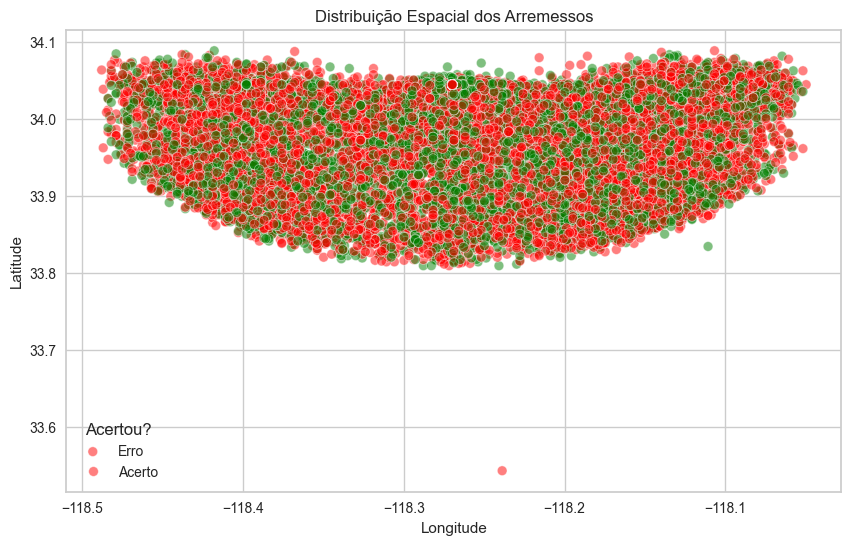

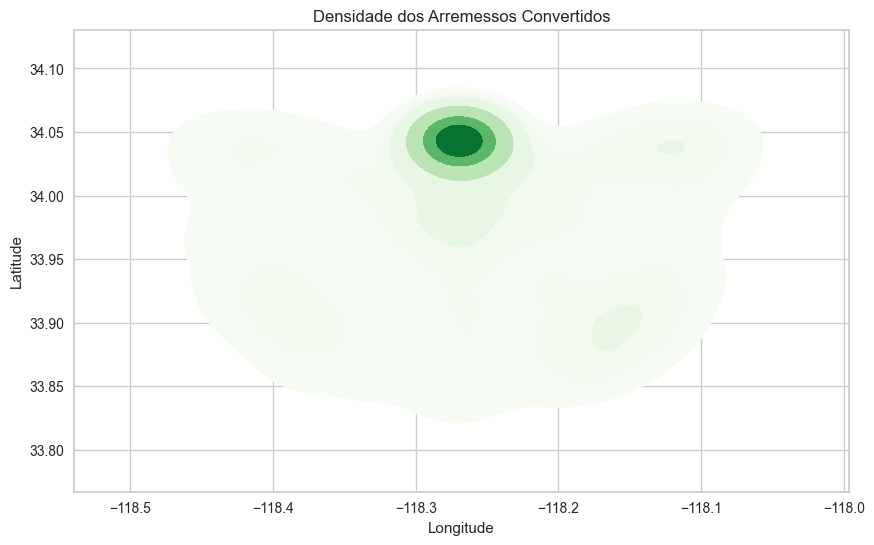

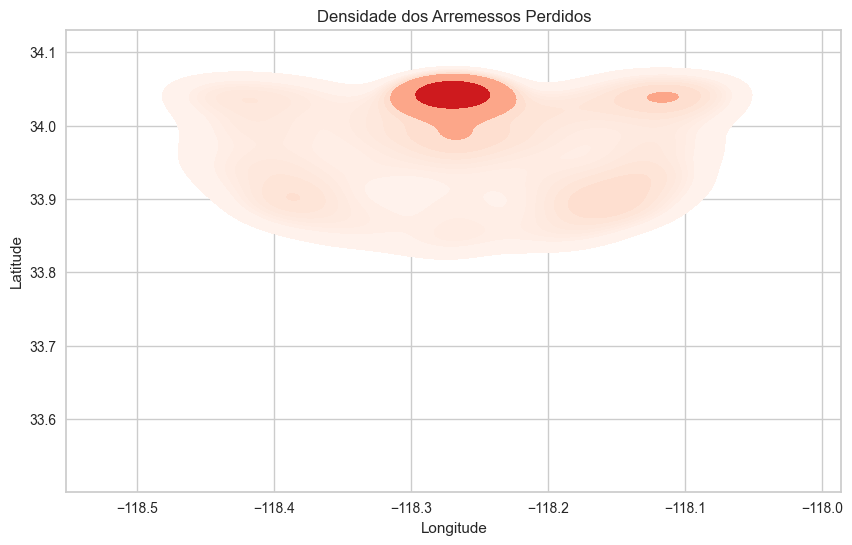

In [13]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Verificar os limites espaciais
print("Latitude - min:", train_df['lat'].min(), "max:", train_df['lat'].max())
print("Longitude - min:", train_df['lon'].min(), "max:", train_df['lon'].max())

# Plotar distribuição dos arremessos no espaço (lat x lon)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="lon", y="lat", hue="shot_made_flag", palette=["red", "green"], alpha=0.5)
plt.title("Distribuição Espacial dos Arremessos")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Acertou?", labels=["Erro", "Acerto"])
plt.grid(True)
plt.show()

# Densidade de acertos
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df[df["shot_made_flag"] == 1],
    x="lon", y="lat", fill=True, cmap="Greens", thresh=0.05
)
plt.title("Densidade dos Arremessos Convertidos")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Densidade de erros
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df[df["shot_made_flag"] == 0],
    x="lon", y="lat", fill=True, cmap="Reds", thresh=0.05
)
plt.title("Densidade dos Arremessos Perdidos")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()